# Symmetry-adapted tensor

This example shows how to calculate irreps of crystallographic point groups and construct projection operator on identity representation.
We apply the projection operator to obtaining symmetry-adapted tensor (e.g. elastic constant).

## Import modules

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from spglib import get_symmetry_from_database

import spgrep
from spgrep import get_crystallographic_pointgroup_irreps_from_symmetry
from spgrep.group import get_cayley_table
from spgrep.representation import is_representation, project_to_irrep
from spgrep.tensor import get_symmetry_adapted_tensors, apply_intrinsic_symmetry

print(f"spgrep=={spgrep.__version__}")

spgrep==0.3.4.dev177+gd763494


In [2]:
sns.set_context("poster")

## Prepare point-group operations and representation

We consider crystallographic point group $m\overline{3}m$.

In [3]:
# Pm-3m (No. 221)
symmetry = get_symmetry_from_database(hall_number=517)
rotations = symmetry["rotations"]  # (48, 3, 3)

Then, we define basis of strain tensors in Voigt order:

$$
    \mathbf{E}_{1} =
        \begin{pmatrix}
            1 & 0 & 0 \\
            0 & 0 & 0 \\
            0 & 0 & 0 \\
        \end{pmatrix},
    \mathbf{E}_{2} =
        \begin{pmatrix}
            0 & 0 & 0 \\
            0 & 1 & 0 \\
            0 & 0 & 0 \\
        \end{pmatrix},
    \mathbf{E}_{3} =
        \begin{pmatrix}
            0 & 0 & 0 \\
            0 & 0 & 0 \\
            0 & 0 & 1 \\
        \end{pmatrix},
    \mathbf{E}_{4} =
        \frac{1}{\sqrt{2}}
        \begin{pmatrix}
            0 & 0 & 0 \\
            0 & 0 & 1 \\
            0 & 1 & 0 \\
        \end{pmatrix},
    \mathbf{E}_{5} =
        \frac{1}{\sqrt{2}}
        \begin{pmatrix}
            0 & 0 & 1 \\
            0 & 0 & 0 \\
            1 & 0 & 0 \\
        \end{pmatrix},
    \mathbf{E}_{6} =
        \frac{1}{\sqrt{2}}
        \begin{pmatrix}
            0 & 1 & 0 \\
            1 & 0 & 0 \\
            0 & 0 & 0 \\
        \end{pmatrix}.
$$

A rotation $R$ in point group $\mathcal{P}$ acts the basis of strain tensors as

$$
    R \mathbf{E}_{j} := \mathbf{R} \mathbf{E}_{j} \mathbf{R}^{\top} \quad (R \in \mathcal{P}),
$$

where $\mathbf{R}$ is a matrix representation of rotation $R$.
We define a representation matrix for this action as

$$
    R \mathbf{E}_{j} = \sum_{i=1}^{6} \mathbf{E}_{i} \Gamma_{ij}(R).
$$

In [4]:
def get_standard_basis() -> list[np.ndarray]:
    # Basis for symmetric matrix in Voigt order (xx, yy, zz, yz, zx, xy)
    basis = [
        np.array(
            [
                [1, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
            ],
            dtype=np.float64,
        ),
        np.array(
            [
                [0, 0, 0],
                [0, 1, 0],
                [0, 0, 0],
            ],
            dtype=np.float64,
        ),
        np.array(
            [
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 1],
            ],
            dtype=np.float64,
        ),
        np.array(
            [
                [0, 0, 0],
                [0, 0, 1],
                [0, 1, 0],
            ],
            dtype=np.float64,
        )
        / np.sqrt(2),
        np.array(
            [
                [0, 0, 1],
                [0, 0, 0],
                [1, 0, 0],
            ],
            dtype=np.float64,
        )
        / np.sqrt(2),
        np.array(
            [
                [0, 1, 0],
                [1, 0, 0],
                [0, 0, 0],
            ],
            dtype=np.float64,
        )
        / np.sqrt(2),
    ]
    return basis


def get_representation_on_symmetric_matrix(rotations: np.ndarray) -> np.ndarray:
    # take [e_{1,1}, e_{2,2}, e_{3,3}, e_{2,3}, e_{3,1}, e_{1,2}] as basis
    basis = get_standard_basis()
    rep = np.zeros((len(rotations), len(basis), len(basis)))
    for pos, rotation in enumerate(rotations):
        for j, bj in enumerate(basis):
            # operated = rotation.T @ bj @ rotation
            operated = rotation @ bj @ rotation.T
            for i, bi in enumerate(basis):
                rep[pos, i, j] = np.sum(operated * bi) / np.sum(bi * bi)

    # Sanity check if `rep` satisfy property of representation
    table = get_cayley_table(rotations)
    assert is_representation(rep, table)

    return rep


rep = get_representation_on_symmetric_matrix(rotations)

Of course, the representation matrices are not block-diagonalized:

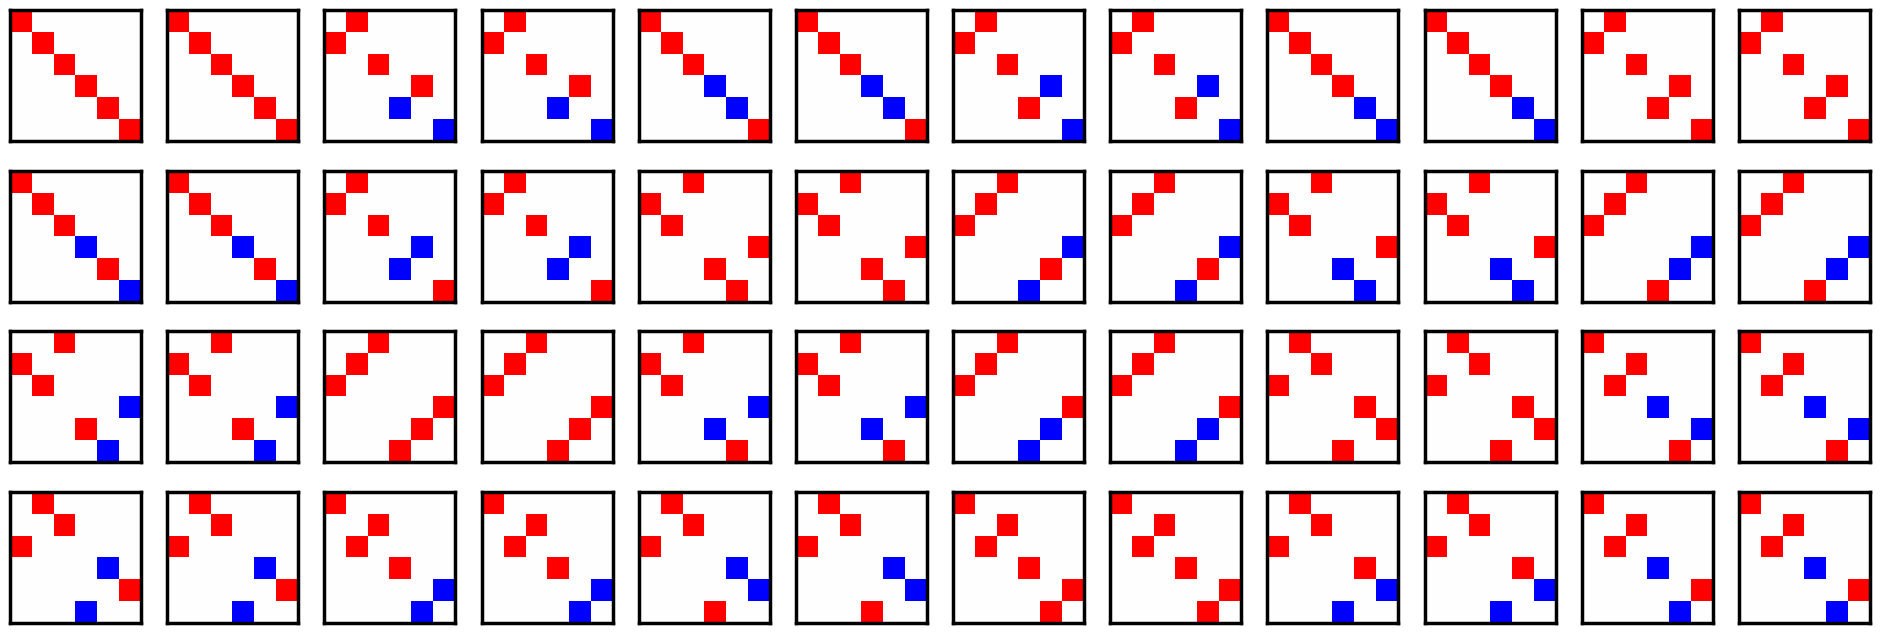

In [5]:
nrows = 4
ncols = 12
fig, axes = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax = axes[row][col]
        ax.imshow(rep[idx], cmap="bwr", vmin=-1, vmax=1)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])

## Calculate physically irreducible representation
For strain tensors, we need to consider representation over real number $\mathbb{R}$.
The `spgrep.get_crystallographic_pointgroup_irreps_from_symmetry` with `real=True` returns all unitary irreps over real number $\mathbb{R}$ (also called as *physically irreducible representation*).

In [6]:
irreps = get_crystallographic_pointgroup_irreps_from_symmetry(rotations, real=True)

Basis functions for each irrep can be obtained by `spgrep.representation.project_to_irrep`:

In [7]:
all_basis = []
for irrep in irreps:
    list_basis = project_to_irrep(rep, irrep)
    for basis in list_basis:
        all_basis.append(basis)

We can confirm the representation $\Gamma$ is decomposed to three irreps: a one-dimensional, a two-dimensional, and a three-dimensional ones.

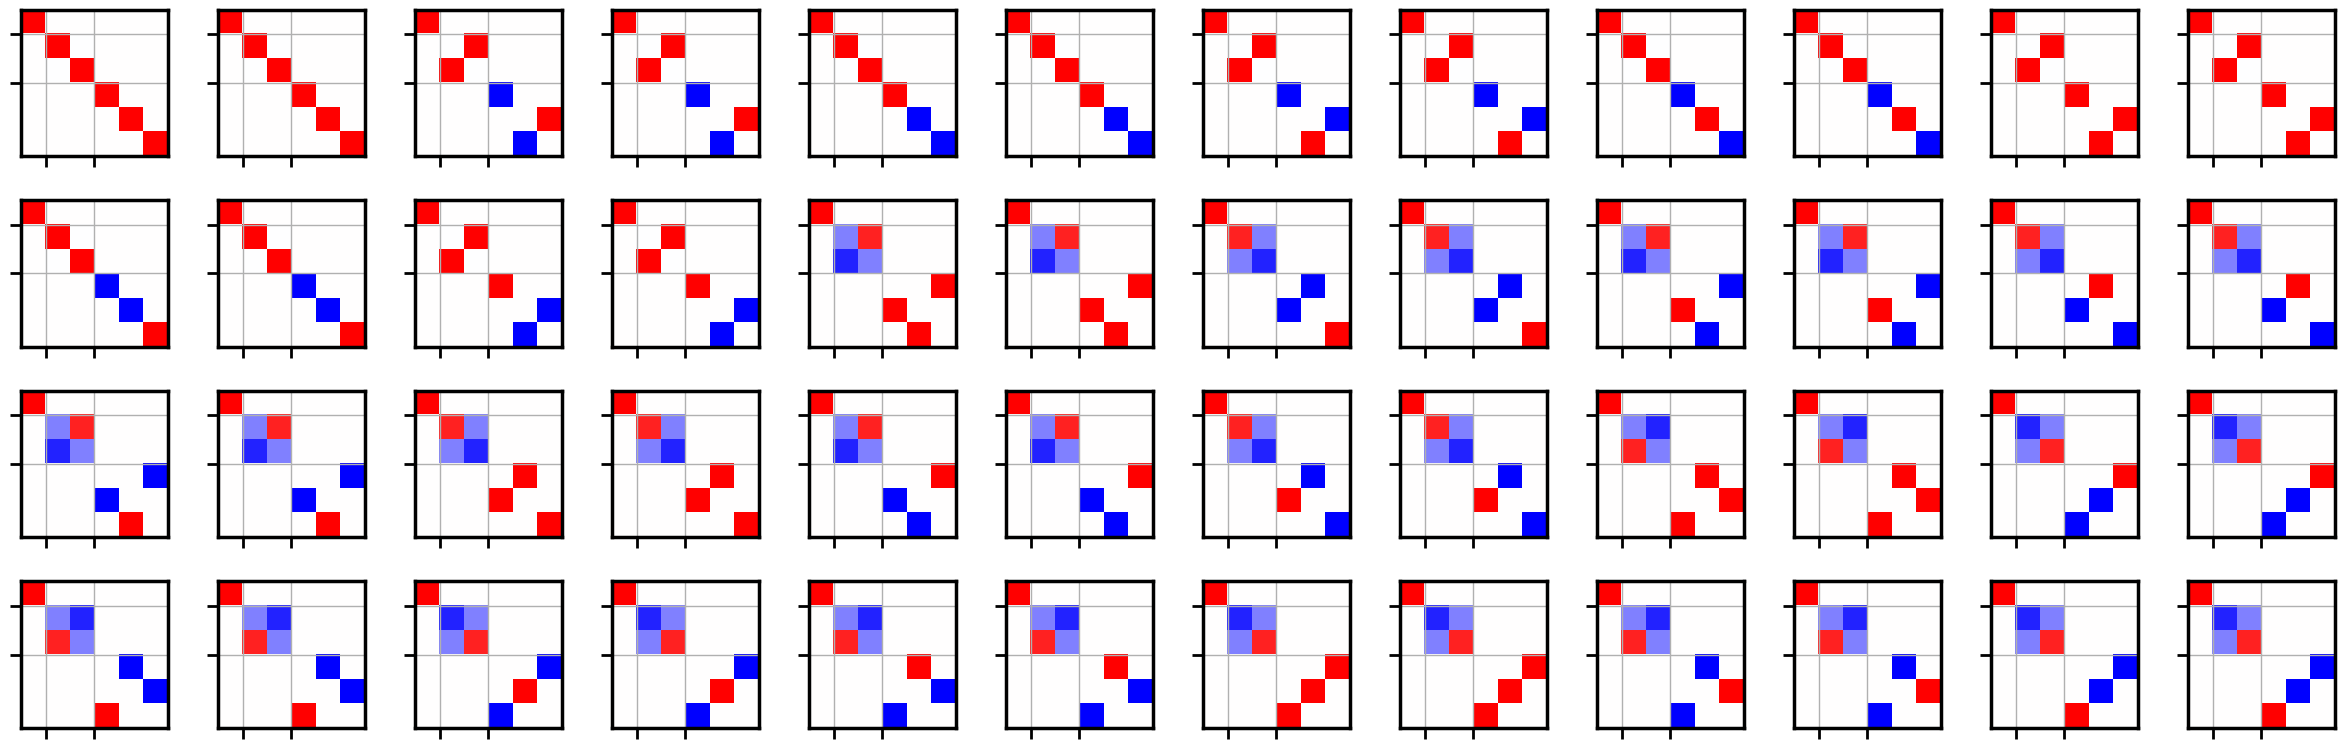

In [8]:
fig, axes = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax = axes[row][col]
        rep_transformed = np.concatenate(all_basis) @ rep[idx] @ np.concatenate(all_basis).T
        ax.imshow(rep_transformed, cmap="bwr", vmin=-1, vmax=1, aspect="equal")
        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_xticks([0.5, 2.5], minor=True)
        ax.set_yticks([0.5, 2.5], minor=True)
        ax.grid(which="minor", linewidth=1)

plt.tight_layout()

## Calculate symmetry-adapted tensors

In [9]:
expects = [1, 3, 6, 11]
for rank, expect in zip(range(1, len(expects) + 1), expects):
    tensors = get_symmetry_adapted_tensors(rep, rotations, rank, real=True)
    sym_tensors = apply_intrinsic_symmetry(tensors)
    print(f"Rank={rank}: {len(sym_tensors)}")
    assert len(sym_tensors) == expect

Rank=1: 1
Rank=2: 3
Rank=3: 6
Rank=4: 11
